In [1]:
import os
import pickle as pkl
import sys

import bokeh
import numpy as np
import pandas as pd
from bokeh.layouts import column
from bokeh.models import BoxZoomTool, HoverTool, ResetTool, TapTool
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.plotting import Figure as bokehfigure
from bokeh.plotting import figure as bokehfigure
from bokeh.plotting import save as bokehsave
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
print ("bokeh version", bokeh.__version__)
#, HBox, VBoxForm, BoxSelectTool, TapTool
#from bokeh.models.widgets import Select
#Slider, Select, TextInput
from bokeh.plotting import output_file
import matplotlib.gridspec as gridspec

try:
    os.environ['SESNPATH']
    os.environ['SESNCFAlib']
    os.environ['UTILPATH']

except KeyError:
    print ("must set environmental variable SESNPATH and SESNCfAlib")
    sys.exit()

bokeh version 1.3.4


In [3]:
cmd_folder = os.getenv("SESNCFAlib")
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
cmd_folder = os.getenv("SESNCFAlib") + "/templates"
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
    
from ubertemplates import *

cmd_folder = os.getenv("UTILPATH")
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

In [4]:
from snclasses import *
from templutils import *
from makePhottable import *
from colors import rgb_to_hex

In [5]:
MINEP, MAXEP = -100, 365.25 * 2
archetypicalSNe = ['94I', '93J', '08D', '05bf', '04aw', '10bm', '10vgv']

colorTypes = {'IIb':'FireBrick',
             'Ib':'SteelBlue',
             'Ic':'DarkGreen',
             'Ic-bl':'DarkOrange',
             'other':'purple'}

#prepping SN data from scratch
#(dont do that if you are testing or tuning plots)
# PREP = Tru/e 
PREP = False
BOKEHIT = True
#BOKEHIT = False
font = {'family' : 'normal',
        'size'   : 20}


In [6]:
su = setupvars()

In [7]:
pl.rc('font', **font)

In [8]:
inputSNe = pd.read_csv(os.getenv("SESNCFAlib") +
                           "/SESNessentials.csv")['SNname'].values#[:5]

if os.path.isfile('input/sncolors.pkl'):
    print ('reading sncolors')
    with open('input/sncolors.pkl', 'rb') as f:
        sncolors = pkl.load(f, encoding="latin")
    # sncolors =  pkl.load(open('input/sncolors.pkl'))

    if not len(sncolors) == len(inputSNe):
        print ("redoing SNcolors")
        #raw_input()

        sncolors = setcolors(inputSNe)
else:
    sncolors = setcolors(inputSNe)   

reading sncolors


In [9]:
b = su.bands
dms = {}
workBands = b

if PREP:
    allSNe = preplcvs(inputSNe, workBands)
else:
    allSNe = {}
#     allSNe = pkl.load(open('input/allSNe.pkl'), encoding='utf-8')
    file = open('input/allSNe.pkl', 'rb')
    allSNe = pickle.load(file, encoding='latin')
    file.close()

54A B has no datapoints between near 0. Moving on
97ef B has no datapoints between near 0. Moving on
01ig B has no datapoints between near 0. Moving on
03bg B has no datapoints between near 0. Moving on
04gq B has no datapoints between near 0. Moving on
04gt B has no datapoints between near 0. Moving on
05az B has no datapoints between near 0. Moving on
06cb B has no datapoints between near 0. Moving on
06lc B has no datapoints between near 0. Moving on
07cl B has no datapoints between near 0. Moving on
PS1-12sk B has no datapoints between near 0. Moving on
OGLE-2012-sn-006 B has no datapoints between near 0. Moving on
iPTF15dtg B has no datapoints between near 0. Moving on
16gkg B has no datapoints between near 0. Moving on
05la B has no datapoints between near 0. Moving on
calculating stats and average  B


/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater
/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater
/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater
/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater
/Users/somayeh/opt/anaconda3/lib/python3.7/site-

outputs/UberTemplate_B.html


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.




 bokeh plot saved to outputs/UberTemplate_B.html


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


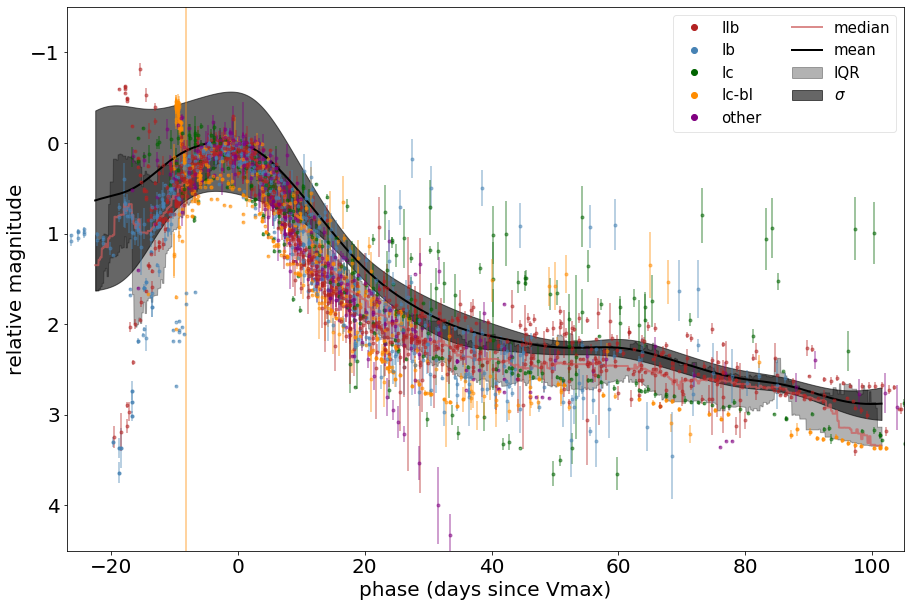

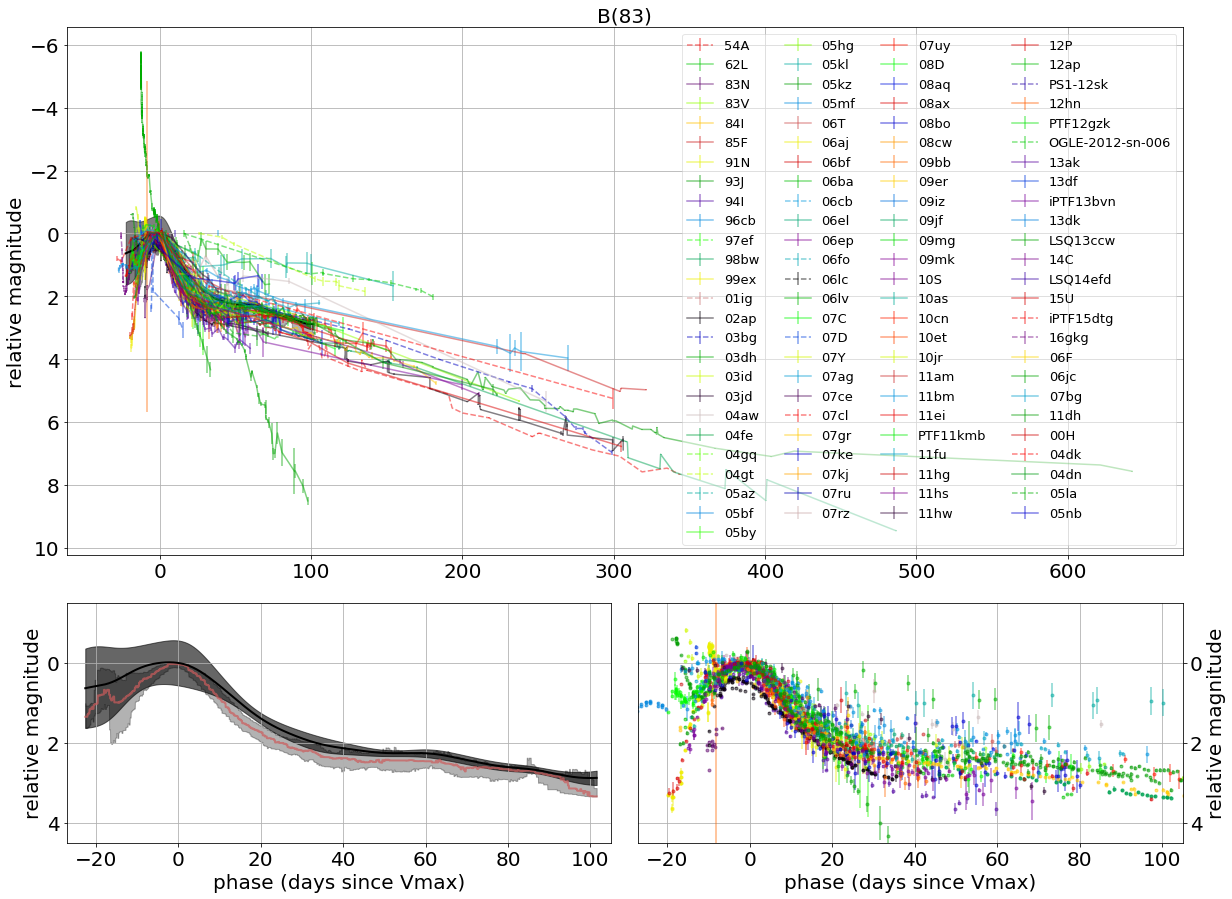

In [10]:
b = 'B'
fig = pl.figure(figsize=(15, 10))
axtype = fig.add_subplot(111)



source = ColumnDataSource(data={})
source.data, ax = plotme(allSNe[b], b, sncolors, axtype=axtype)




x = np.array(source.data['x']) #timeline
if len(x)<2:
    print('ERROR: Less than two data points!')
#select max 2 obs per day
source.data = select2ObsPerDay(source.data)
#selectOneEpochPerDay(source.data)
#remove phases >100 days
indx1 = (x<100) & (~np.array(source.data['mask']))
x = x[indx1] 

if  len(x) == 0:
    print('ERROR : No data points left!')

#sort all epochs
indx = np.argsort(x)
x = x[indx]

#create phases every hour from first dp to 100 days
phases = np.arange(x[0], 100,  1.0/24.0)
#observed magnitudes and errors
y = - np.array(source.data['y'])[indx1][indx]
yerr = np.array(source.data['yerr'])[indx1][indx]


# save all anonymized photometric datapoints
dataphases = {'x': x, 'y': y, 'yerr': yerr, 'phases': phases,
          'allSNe': allSNe[b]}

# pkl.dump(dataphases, open('data/alldata_%s.pkl' % b, 'wb'))

print ("calculating stats and average ", b)

#fixing yerr that are nan to 0.3 mag
yerr = dataphases['yerr']
yerr[np.isnan(yerr) * ~(np.isfinite(yerr))] = 0.3
yerr[yerr==0] = 0.1

#gaussian sigma 5 hours - empirically found to be good for most bands, esp V
gsig = 5

#set larger gaussian kernel for poorly observed bands (IR, u)
if b in ['K','H','J','i','u','U']:
    gsig = gsig * 2

#set weighted averge, median etc
phs, wmu, wgstd, mu, med, std, wstd, dm, pc25, pc75 = wAverageByPhase(dataphases, gsig)
dms[b] = dm

wmu[std==0] = np.nan
wmu = wmu - wmu[np.abs(phs) == min(np.abs(phs))]

smoothedmean = np.empty_like(mu) * np.nan

ax[0].plot(phs, med, 'r-', alpha=0.7, lw=2)
ax[0].plot(phs[std>0], wmu[std>0], 'k-', lw=2)

ax[0].fill_between(phs[std>0],
                   pc25[std>0],
                   pc75[std>0],
                   color = 'k', alpha=0.3)        
ax[0].fill_between(phs[std>0], wmu[std>0]-wgstd[std>0],
                   wmu[std>0]+wgstd[std>0],
                   color = 'k', alpha=0.5)                

ax1 = pl.subplot(ax[2][-1,0])
#ax1.plot(phs, mu, 'g-', lw=1, alpha=0.7, label="rolling mean")




for thisax in [ax1, axtype]:
    thisax.fill_between(phs[std>0],
                     pc25[std>0],
                     pc75[std>0],
                     color = 'k', alpha=0.3, label="IQR")
    #ax1.fill_between(phs[std>0], wmu[std>0]-std[std>0], wmu[std>0]+std[std>0],
    #                 color = 'k', alpha=0.3, label=r"$\sigma$")

    thisax.fill_between(phs[std>0], wmu[std>0]-wgstd[std>0],
                     wmu[std>0]+wgstd[std>0],
                     color = 'k', alpha=0.6, label=r"$\sigma$")        
    thisax.plot(phs, med, '-', color = 'IndianRed', alpha=0.7,
             lw=2, label="median")
    thisax.plot(phs[std>0], wmu[std>0], 'k-', lw=2, label="mean")
    #ax1.plot(x, -smoothedmean, '-', color = 'SteelBlue', lw=2, label="smoothed")        
    #ax1.plot(phs, mymean, '-', color='yellow', alpha=0.7, lw=2,
    #         label="my mean")
    thisax.set_ylabel("relative magnitude", fontsize = 20)
    thisax.set_xlabel("phase (days since Vmax)", fontsize = 20)
    thisax.set_ylim(4.5, -1.5)#ax1.get_ylim()[1], ax1.get_ylim()[0])
    thisax.set_xlim(-27, 105)

handles, labels = axtype.get_legend_handles_labels()
artistIIb = pl.Line2D((0,1),(0,0), color=colorTypes['IIb'],
                      marker = 'o', linestyle='')
artistIb = pl.Line2D((0,1),(0,0), color=colorTypes['Ib'],
                     marker = 'o', linestyle='')
artistIc = pl.Line2D((0,1),(0,0), color=colorTypes['Ic'],
                     marker = 'o', linestyle='')
artistIcbl = pl.Line2D((0,1),(0,0), color=colorTypes['Ic-bl'],
                       marker = 'o', linestyle='')
artistother = pl.Line2D((0,1),(0,0), color=colorTypes['other'],
                        marker = 'o', linestyle='')
axtype.legend([artistIIb, artistIb, artistIc, artistIcbl, artistother] + 
              [handle for handle in handles],
              ['IIb','Ib','Ic','Ic-bl','other'] +
              [label for label in labels],
              framealpha=0.5, ncol=2, prop={'size': 15})

        
ax[1].set_ylim(4.5, -1.5)#ax[1].get_ylim()[0], ax[1].get_ylim()[1])
#pl.show()
ax1.grid(True)    

# pl.savefig("outputs2/UberTemplate_%s.pdf" % \
#            (b + 'p' if b in ['u', 'r', 'i']
#                                     else b))
# fig.savefig("outputs2/UberTemplate_%s_types.pdf" % \
#            (b + 'p' if b in ['u', 'r', 'i']
#                                     else b))

#pl.show() 


if BOKEHIT:
    bokehplot(source, np.asarray(wmu), np.asarray(wgstd), np.asarray(phs), b)

ut = {}#pd.DataFrame()
ut['phs'] = phs
ut['med'] = med

ut['mu'] = wmu
ut['mu'][ut['mu'] == 0] = np.nan

ut['std'] = std
ut['wstd'] = wgstd        
ut['pc25'] = pc25
ut['pc75'] = pc75
        
ut, ut['spl'] = wSmoothAverage(ut,  3)


#ut['spl'] = ut['mu']

# pkl.dump(ut, open("outputs2/UberTemplate_%s.pkl" % \
#            (b + 'p' if b in ['u', 'r', 'i']
#                                     else b), 'wb'))
# redo for R and V up to 40 days only


#     pkl.dump(ut2, open("outputs2/UberTemplate_%s40.pkl"%b, 'wb'))      


# pd.DataFrame.from_dict(dms, orient='index').\
# to_csv("outputs2/dmsUberTemplates.csv")

In [12]:
data = dataphases
sigma = 5
phsmax = 100
window = 5
err = True


dm_ = {}

phs_ =  np.arange(-20 - window, phsmax + window,
                 1.0/24) # every hour in days

N = len(phs)
wmu_ = np.zeros(N) * np.nan
med_ = np.zeros(N) * np.nan
std_ = np.zeros(N) * np.nan
wstd_ = np.zeros(N) * np.nan
wgstd_ = np.zeros(N) * np.nan        
wgmu_ = np.zeros(N) * np.nan 
wgstd2 = np.zeros(N) * np.nan        
wgmu2 = np.zeros(N) * np.nan
wgstd3 = np.zeros(N) * np.nan        
wgmu3 = np.zeros(N) * np.nan
wgstd4 = np.zeros(N) * np.nan        
wgmu4 = np.zeros(N) * np.nan
pc25_ = np.zeros(N) * np.nan
pc75_ = np.zeros(N) * np.nan  

In [13]:
#sad c-style loop
for i, hour in enumerate(phs_):
    # I need at least 1 datapoint within 3 hours of the target hour (to take median)
    indx = (data['x'] >= hour) * (data['x'] < hour + window)
#     print (i, hour + window/24., indx.sum())

    #remove if less than 3 datapoints within 4 hours

    if indx.sum() < 3:
        continue
    

    #weighted average weighted by errorbars within hour and hour+window

    weights = 1.0 / ((data['yerr'][indx])**2)

    wmu_[i] = np.average(data['y'][indx], axis = 0,
                        weights=weights)
    std_[i] = np.std(data['y'][indx]) 

    wstd_[i] = np.average((data['y'][indx]-wmu[i])**2,  axis = 0,
                         weights=weights)
    #median
    #med[i] = np.median(data['y'][indx])
    pc25_[i], med_[i], pc75_[i] = np.percentile(data['y'][indx], [25, 50, 75])



In [14]:
interpmed = np.poly1d(np.polyfit(phs_[~np.isnan(med_)],
                                 wmu_[~np.isnan(med_)],3))
# below checks the polynnomial spline that is removed before smoothing to avoid regression to mean

# pl.figure()
# pl.plot(phs[~np.isnan(med)],wmu[~np.isnan(med)],'.')
# pl.plot(data['x'], interpmed(data['x']))
# plt.gca().invert_yaxis()
# pl.show()

for i, hour in enumerate(phs_):

    #exponential decay importance with time
    gtemp_ = np.exp(-(data['x'] - hour - window * 0.5)**2 * 0.5 / sigma**2)
                   #np.exp(((data['x'] - hour - window * 0.5) /
    #                sigma)**2 / 2)
    weights = 1.0/((data['yerr'])**2) * gtemp_
    wgmu_[i] = np.average(data['y'] - interpmed(data['x']),
                        weights=weights) 
    wgstd_[i] = np.average((data['y'] - interpmed(data['x']))**2,  axis = 0,
                         weights=weights)
    
#     wgmu2[i] = np.average(data['y'],
#                         weights=weights) 
#     wgstd2[i] = np.average((data['y'])**2,  axis = 0,
#                          weights=weights)
    
#     wgmu3[i] = np.average(data['y'] - interpmed(data['x']),
#                         weights=weights) 
#     wgstd3[i] = np.average((data['y'] - interpmed(data['x']) - wgmu3[i])**2,  axis = 0,
#                          weights=weights)
    
#     wgmu4[i] = np.average(data['y'],
#                         weights=weights) 
#     wgstd4[i] = np.average((data['y'] - wgmu4[i])**2,  axis = 0,
#                          weights=weights)


#add back polynomial to fit general trend
wgmu_ = wgmu_ + interpmed(phs_)



In [35]:
(data.keys())

dict_keys(['x', 'y', 'yerr', 'phases', 'allSNe'])

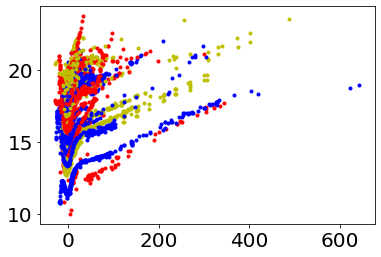

In [33]:
for i, name in enumerate(data['allSNe']['name']):
    
    if data['allSNe']['type'][i].startswith('IIb'):
        plt.plot(data['allSNe']['phase'][i], data['allSNe']['mag'][i], '.', color = 'b')
        
    if data['allSNe']['type'][i].startswith('Ib'):
        plt.plot(data['allSNe']['phase'][i], data['allSNe']['mag'][i], '.', color = 'r')
        
    if data['allSNe']['type'][i].startswith('Ic'):
        plt.plot(data['allSNe']['phase'][i], data['allSNe']['mag'][i], '.', color = 'y')

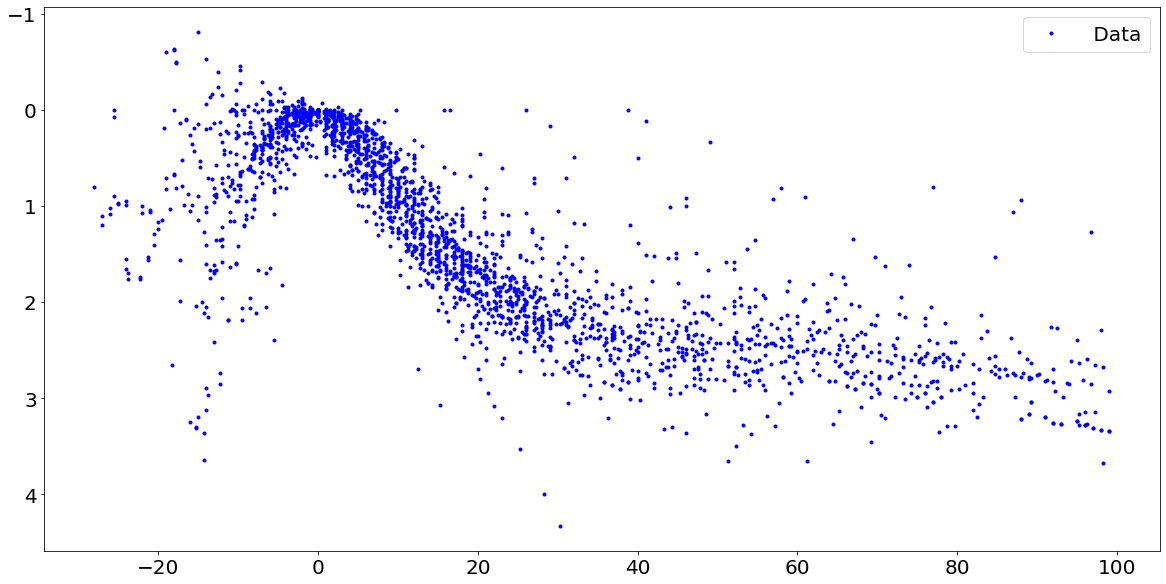

In [15]:
plt.figure(figsize=(20,10))
plt.plot(data['x'], data['y'], 'b.' , label= ' Data')
# plt.plot(phs[std>0]+window/2., wgmu[std>0], '.', label = 'Uber Template_fbb')
# plt.plot(phs_[std_>0]+window/2., wgmu_[std_>0], '.', label = 'Uber Template_jpy')


# plt.plot(phs[std>0]+window/2., wgmu2[std>0], '.', label = 'Uber Template no polynomial subtraction')
# plt.plot(phs+window/2., wgmu3, '.', label = 'Uber Template with std - wgmu')
# plt.plot(phs+window/2., wgmu4, '.', label = 'Uber Template no polynomial subtraction with std - wgmu')


# plt.plot(phs+window/2., med, 'r.', label = 'Median Template')
# plt.plot(phs+window/2., wmu, 'y.', label= 'Weighted Average')

plt.legend()

plt.gca().invert_yaxis()



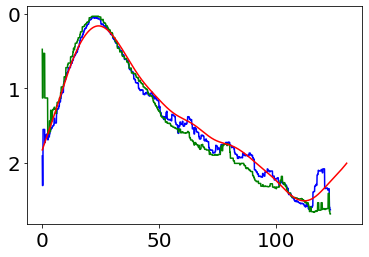

In [88]:

phs = phs + window * 0.5 #shift all phases by 1.5 hours

phs0 = np.abs(phs) == min(np.abs(phs))
phs15 = np.abs(phs - 15) == min(np.abs(phs - 15))
phsm10 = np.abs(phs + 10) == min(np.abs(phs + 10))

# print (phs0, phs15, phsm10)

dm['15'],dm['15min'],dm['15max'] = (wmu[phs0] - wmu[phs15])[0],\
            (wmu[phs0] - wgstd[phs0] - (wmu[phs15] + wgstd[phs15]))[0],\
            (wmu[phs0] + wgstd[phs0] - (wmu[phs15] - wgstd[phs15]))[0]

dm['-10'],dm['-10min'],dm['-10max'] = (wmu[phsm10] - wmu[phs0])[0],\
             (wmu[phsm10] -  wgstd[phsm10] - (wmu[phs0] + wgstd[phs0]))[0],\
             (wmu[phsm10] +  wgstd[phsm10] - (wmu[phs0] - wgstd[phs0]))[0]


# plt.errorbar(data['x'], data['y'], yerr=data['yerr'],
#            color='k', fmt='.')
plt.plot(phs, wmu, 'b')
plt.plot(phs, med, 'g')
plt.plot(phs, wgmu, 'r')
plt.gca().invert_yaxis()
# return phs, wgmu, wgstd, wmu, med, std, wstd, dm, pc25, pc75



In [80]:
dm

{'15': -0.4720907285809517,
 '15min': -0.8140097483992577,
 '15max': -0.13017170876264572,
 '-10': 0.7821466401219368,
 '-10min': 0.2644232138991356,
 '-10max': 1.299870066344738}